In [42]:
import cv2
import glob
import numpy as np
import csv
import pandas as pd
from matplotlib import pyplot as plt

In [6]:
# save images to a csv file, one row per image
# @param imgDir: directory name of the images
# @param csvpath: name of the csv file
# @param number: number of images to save
# @param label: label of the images, 0 for normal, 1 for pneumonia
def imgToCsv(imgDir, csvPath, number, label):
    with open(csvPath, mode='a+') as file:
        writer = csv.writer(file) 
        count = 0
        for currImg in glob.glob(imgDir+'/*.jpeg'):
            img = cv2.imread(currImg)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (100, 100))
            img = img.reshape(1, -1)
            imgList = [label]
            for i in range(len(img[0])):
                imgList.append(img[0][i])
            writer.writerow(imgList)
            count += 1
            if count == number:
                break

In [7]:
# clear a csv file
# @param csvPath: name of csv file
def clearCsv(csvPath):
    f = open(csvPath, 'r+')
    f.truncate(0) 
    f.close()

# Convert Images to CSV

In [16]:
imgToCsv('normal', 'xray_images.csv', 1000, 0)

In [17]:
imgToCsv('pneumonia', 'xray_images.csv', 1000, 1)

In [18]:
images = pd.read_csv('xray_images.csv', header=None)
data = images
data.shape

(2000, 10001)

# PCA

In [182]:
from sklearn.preprocessing import StandardScaler
features = data.loc[:,1:data.shape[1]] #all features
labels = data.loc[:,0] #all labels
features = StandardScaler().fit_transform(features) #standarlize all the features

In [183]:
from sklearn.decomposition import PCA
pca = PCA(n_components=features.shape[0])
principalComponents = pca.fit_transform(features)
principalDf = pd.DataFrame(data = principalComponents) #principal components

In [184]:
finalDf = pd.concat([labels, principalDf], axis = 1) #add in the all labels
finalDf.shape

(2000, 2001)

Text(0, 0.5, ' total information')

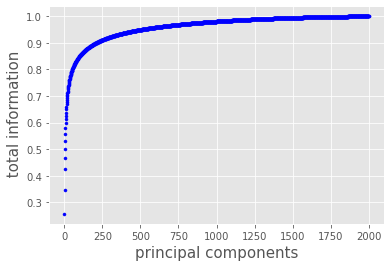

In [185]:
ratio = pca.explained_variance_ratio_ #information(variance) of each of the principal components
variance = 0
count = 0
for value in ratio: #sum the each component's covered information one by one
    variance += value
    count += 1
    plt.scatter(count, variance, c = 'b', marker = '.') #show the trends of total information
plt.xlabel('principal components', fontsize = 15)
plt.ylabel(' total information', fontsize = 15)

# Logistic Regression

In [300]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import log_loss
import timeit
from sklearn.model_selection import cross_val_score

## LR on Principal Dimensions

In [410]:
#70% train, 30% test
x_train, x_test, y_train, y_test = train_test_split(finalDf.iloc[:,1:], finalDf.iloc[:,0], test_size = 0.3, shuffle = True)

In [411]:
start = timeit.default_timer() 
LR = LogisticRegression(max_iter=600)
LR.fit(x_train, y_train)
prediction = LR.predict(x_test) #predicton
accuracy1 = LR.score(x_test, y_test) #score of prediction
end = timeit.default_timer()
duration1 = end - start #running time
print('Accuracy: ', accuracy1)

Accuracy:  0.9466666666666667


In [412]:
prob = LR.predict_proba(x_test) #probabilities of lable 1 for each prediction
loss1 = log_loss(y_test, prob) #loss of the prediction
print(loss1)

0.2389197666264811


Text(0.5, 1.0, 'label probability')

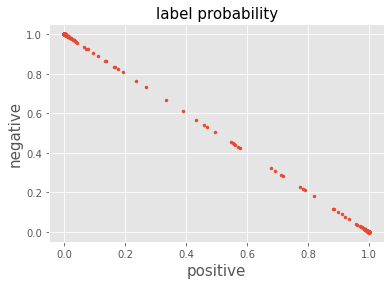

In [393]:
plt.scatter(prob[:,0], prob[:,1], marker='.')
plt.xlabel('positive', fontsize = 15)
plt.ylabel('negative', fontsize = 15)
plt.title('label probability', fontsize = 15)

In [398]:
count = 0
for i in range(len(prob)):
    if (prob[i,0] > 0.9) or (prob [i,1] > 0.9):
        count+=1
certainty1 = count/len(prob)
print('Certainty Rate:', certainty1)

Certainty Rate: 0.9466666666666667


In [395]:
#10-folds cross validation
scores = cross_val_score(LR, x_train, y_train, cv=10)
scores = pd.Series(scores)
cross_score1 = scores.mean()
print("10-folds Cross Validation Score:", cross_score1)

10-folds Cross Validation Score: 0.9421428571428571


In [397]:
scores.max()

0.9571428571428572

## LR on Full Dimensions

In [407]:
#70% train, 30% test
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,1:], data.iloc[:,0], test_size = 0.3, shuffle = True)

In [408]:
start = timeit.default_timer()
LR = LogisticRegression(max_iter=600)
LR.fit(x_train, y_train)
prediction = LR.predict(x_test) #prediction
accuracy2 = LR.score(x_test, y_test) #model score
end = timeit.default_timer()
duration2 = end - start #running time
print('Accuracy: ', accuracy2)

Accuracy:  0.955


In [409]:
prob = LR.predict_proba(x_test) #probabilities of lable 1 for each prediction
loss2 = log_loss(y_test, prob) #loss of the prediction
print(loss2)

0.31411028597081464


Text(0.5, 1.0, 'label probability')

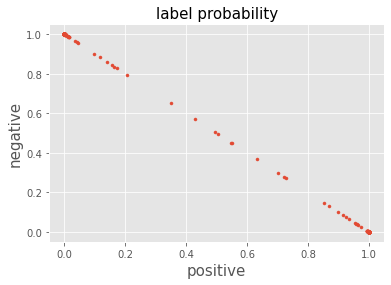

In [385]:
plt.scatter(prob[:,0], prob[:,1], marker='.')
plt.xlabel('positive', fontsize = 15)
plt.ylabel('negative', fontsize = 15)
plt.title('label probability', fontsize = 15)

In [389]:
count = 0
for i in range(len(prob)):
    if (prob[i,0] > 0.9) or (prob [i,1] > 0.9):
        count+=1
certainty2 = count/len(prob)
print('Certainty Rate:', certainty2)

Certainty Rate: 0.9683333333333334


In [375]:
#10-folds cross validation
scores = cross_val_score(LR, x_train, y_train, cv=10)
scores = pd.Series(scores)
cross_score2 = scores.mean()
print("10-folds Cross Validation Score:", cross_score2)

10-folds Cross Validation Score: 0.9357142857142857


In [379]:
scores.max()

0.9571428571428572

## Comparisons 

Text(0.5, 1.0, 'one time prediction')

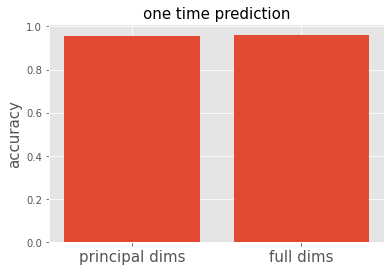

In [368]:
#show accuracies of two modeles
x = [1,2]
plt.bar(x, height=[accuracy1, accuracy2])
plt.xticks(x, ['principal dims','full dims'], fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.title('one time prediction', fontsize=15)

Text(0.5, 1.0, 'cross validated prediction')

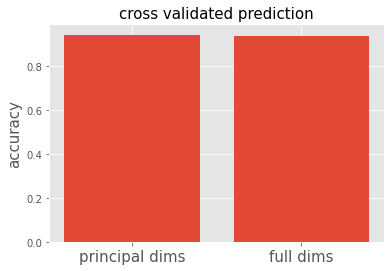

In [416]:
#show validated accuracies of two modeles
x = [1,2]
plt.bar(x, height=[cross_score1, cross_score2])
plt.xticks(x, ['principal dims','full dims'], fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.title('cross validated prediction', fontsize = 15)

Text(0, 0.5, 'loss')

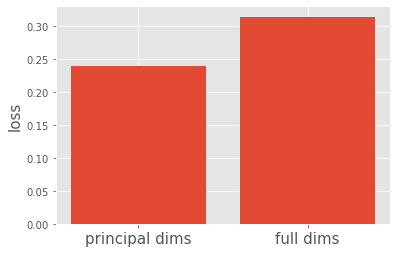

In [413]:
#show loss of two modeles
x = [1,2]
plt.bar(x, height=[loss1,loss2])
plt.xticks(x, ['principal dims','full dims'], fontsize = 15)
plt.ylabel('loss', fontsize = 15)

Text(0, 0.5, 'certainty')

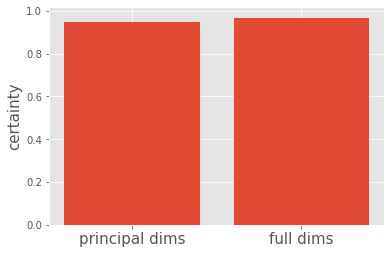

In [414]:
#show certainty of two modeles
x = [1,2]
plt.bar(x, height=[certainty1,certainty2])
plt.xticks(x, ['principal dims','full dims'], fontsize = 15)
plt.ylabel('certainty', fontsize = 15)

#explaination: certainty does not mean accuracy, false positive happen on full dims 
#(certain on incorrect predictions)

Running time on pricipals:  1.0572169160004705
Running time on full dimentions:  13.088632651022635
Ratio:  0.08077367164230624


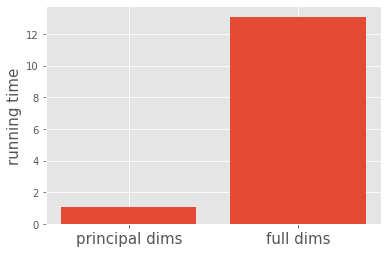

In [418]:
#show running time of two modeles
x = [1,2]
plt.bar(x, height=[duration1, duration2])
plt.xticks(x, ['principal dims','full dims'], fontsize = 15)
plt.ylabel('running time', fontsize = 15)
print('Running time on pricipals: ', duration1)
print('Running time on full dimentions: ', duration2)
print('Ratio: ', duration1/duration2)

# K-Means

In [196]:
%matplotlib inline
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import random

plt.style.use('ggplot')

In [216]:
X = principalDf.loc[1000:2000, :]
# print(X.shape)
C = X.iloc[np.random.randint(X.shape[0], size=2)]
C.shape
clus = np.sqrt(sum((X.iloc[1]-C.iloc[0])**2))
clus
len(X.index)

1000

In [217]:
def k_mean_total_dis(k,it): 
    C = X.iloc[np.random.randint(X.shape[0], size=k)] #random centers
    for itr in range(it): 
        cluster_ind = np.zeros(len(X.index))
        distance = np.zeros((len(X.index), k))
        # find distance of every point to each centroid, and cluster membership
        for k_pos in range(k): 
            for i in range(len(X.index)):
                clus = np.sqrt(sum((X.iloc[i]-C.iloc[k_pos])**2))
                distance[i,k_pos] = clus
        cluster_ind = np.argmin(distance,axis=1)
        for k_pos in range(k):
            ind = []
            val = []
            summ = []
            dist = []
            alldist = []
            for i in range(len(X.index)):
                if (cluster_ind[i]==k_pos):
                    ind.append(i)
                    val.append(X.iloc[i])
                    dist.append(np.sqrt(sum((X.iloc[i]-C.iloc[k_pos])**2)))
            alldist.append(sum(dist))
            if (len(ind)!=0):
                summ = sum(val)
                mean = summ/len(ind)
                C.iloc[k_pos] = mean
    return alldist

In [238]:
totalDist = []
for k in range(1,11):
    dist = k_mean_total_dis(k,100)
    totalDist.append(dist)

/Users/Versace/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-217-1b6696683be1>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  C.iloc[k_pos] = mean


In [239]:
totalDist

[[97780.2643317914],
 [33877.72215992445],
 [21965.64507227402],
 [17837.139405829228],
 [16285.884768418224],
 [12374.82096652662],
 [20227.99248440403],
 [11791.262577937614],
 [8007.468390321226],
 [6788.617367098232]]

Text(0, 0.5, 'total loss')

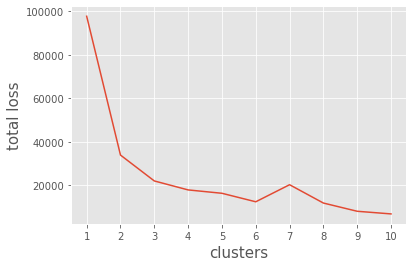

In [330]:
k = np.arange(1, 11)
plt.plot(k,totalDist)
plt.xticks(np.arange(1,11))
plt.xlabel('clusters', fontsize=15)
plt.ylabel('total loss', fontsize=15)